In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp normalize

In [ ]:
# export
from grade_classif.imports import *
from grade_classif.data.dataset import NormDataset
from grade_classif.data.loaders import ImageLoader
from grade_classif.models.plmodules import Normalizer
from grade_classif.params.parser import hparams
from argparse import ArgumentParser
from shutil import copy

In [ ]:
# export
DATA = Path('/data/DeepLearning/SCHWOB_Robin')
INFOLDER = DATA/'Patches_299/Patches_299_1'
OUTFOLDER = DATA/'Patches_normalized_299/Test'
MODELFOLDER = DATA/f'models/logs/level_1/normalizer/'
MODEL = 'cbr_5_32_4'
VERSION = '6cacb7558df8464a843775ca6694ed3b'
BATCH_SIZE = 16
OPEN_MODE = 'H'
GPU = 1

In [ ]:
# export
parser = ArgumentParser()

In [ ]:
# export
parser.add_argument('--file', '-f', help='notebook convenience')
parser.add_argument('--HistoryManager.hist_file', help='nbconvert convenience')
parser.add_argument('--infolder', default=INFOLDER, help="folder containing patches to normalize")
parser.add_argument('--outfolder', default=OUTFOLDER, help="output folder to store normalized patches in")
parser.add_argument('--modelfolder', default=MODELFOLDER, help='folder where model weights are stored')
parser.add_argument('--model', default=MODEL, help="encoder for the normalizer")
parser.add_argument('--version', default=VERSION, help="version of the normalizer to load")
parser.add_argument('--batch-size', type=int, default=BATCH_SIZE, help="size of the batches to load into GPU")
parser.add_argument('--open-mode', choices=['RGB', '3G'], default=OPEN_MODE, help="how the image should be opened (3G for gray and RGB for color)")
parser.add_argument('--gpu', type=int, default=GPU, help="GPU device to tuse")

_StoreAction(option_strings=['--gpu'], dest='gpu', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help='GPU device to tuse', metavar=None)

In [ ]:
hparams.open_mode = 'H'
hparams.transforms = 4
hparams.normalizer = 'cbr_5_32_4'
#hparams.loss = 'mse'
hparams.size = 299
hparams.gpus = [1]
hparams.batch_size = BATCH_SIZE
hparams.patch_classes = None
hparams.norm_csv = None
hparams.concept_classes = None
hparams.level = 1
hparams.loss = 'mse'
hparams.data = Path('/data/DeepLearning/SCHWOB_Robin/Patche_299/Patches_299_1')

In [ ]:
# export
args = parser.parse_args()

In [ ]:
# export
device = torch.device(f'cuda:{args.gpu}')

In [ ]:
slides_1 = list(map(lambda x: INFOLDER/'1'/x, 
                    ['CF_PACS04rescan_06P1056',
                     'CF_PACS04rescan_06P0952',
                     'CF_PACS04rescan_07P0219',
                     'CF_PACS04rescan_06P320',
                     'CF_PACS04rescan_06P1354',
                     'CF_PACS04rescan_06P029',
                     'CF_PACS04rescan_06P1225',
                     'CF_PACS04rescan_07P0220',
                     'CF_PACS04rescan_06P0959',
                     'CF_PACS04rescan_06P0948',
                     'CF_PACS04rescan_06P0825',
                     'CF_PACS04rescan_06P212',
                     'CF_PACS04rescan_06P1099']))

In [ ]:
slides_3 = list(map(lambda x: INFOLDER/'3'/x,
                    ['CF_PACS04rescan_06P1028',
                     'CF_PACS04rescan_06P0619',
                     'CF_PACS04rescan_10F0174',
                     'CF_PACS04rescan_06P1158',
                     'CF_PACS04rescan_06P1080',
                     'CF_PACS05HE_04018-126354',
                     'CF_PACS05HE_02011-12.9168.00.0',
                     'CF_PACS05HE_05020-04B10249.2GSDA',
                     'CF_PACS05HE_08075-A04.4012II3',
                     'CF_PACS05HE_01031-200449RH',
                     'CF_PACS08rescan_436-09C3534',
                     'CF_PACS08rescan_379-09C3052',
                     'CF_PACS08rescan_428-10C3571',
                     'CF_PACS08rescan_301-09C1101',
                     'CF_PACS08rescan_453-10C3337']))

In [ ]:
items = [p for slidefolder in slides_1 + slides_3 for p in slidefolder.iterdir()]

In [ ]:
slides_1 = list((INFOLDER/'1').iterdir())
slides_3 = list((INFOLDER/'3').iterdir())

In [ ]:
slides_1_04 = list(filter(lambda x: 'PACS04' in x.name, slides_1))
slides_1_05 = list(filter(lambda x: 'PACS05' in x.name, slides_1))
slides_1_08 = list(filter(lambda x: 'PACS08' in x.name, slides_1))
slides_3_04 = list(filter(lambda x: 'PACS04' in x.name, slides_3))
slides_3_05 = list(filter(lambda x: 'PACS05' in x.name, slides_3))
slides_3_08 = list(filter(lambda x: 'PACS08' in x.name, slides_3))

In [ ]:
items_1_04 = np.random.choice(slides_1_04, 7, False).tolist()
items_1_05 = np.random.choice(slides_1_05, 6, False).tolist()
items_1_08 = np.random.choice(slides_1_08, 2, False).tolist()
items_1 = items_1_04 + items_1_05 + items_1_08
items_3_04 = np.random.choice(slides_3_04, 5, False).tolist()
items_3_05 = np.random.choice(slides_3_05, 5, False).tolist()
items_3_08 = np.random.choice(slides_3_08, 5, False).tolist()
items_3 = items_3_04 + items_3_05 + items_3_08

In [ ]:
items_1 = [p for slide in map(lambda x: x.iterdir(), items_1) for p in slide]
items_3 = [p for slide in map(lambda x: x.iterdir(), items_3) for p in slide]

In [ ]:
items = items_1 + items_3
labels = ['1'] * len(items_1) + ['3'] * len(items_3)

In [ ]:
# export
ds = (NormDataset(items, items, ImageLoader(), ImageLoader()).
      to_tensor())

In [ ]:
# export
norm = Normalizer(hparams)

In [ ]:
norm.load('6cacb7558df8464a843775ca6694ed3b')

In [ ]:
norm.freeze()

In [ ]:
# export
dl = torch.utils.data.DataLoader(ds, batch_size=args.batch_size, num_workers=2)

In [ ]:
# export
def load_paths(path_list, bs=8):
    for i in range(len(path_list[::bs])):
        yield path_list[bs*i:bs*(i+1)]

In [ ]:
# export
for (x, _), paths in tqdm(zip(dl, load_paths(ds.items, bs=args.batch_size)), total=len(dl)):
    x = x.to(norm.main_device)
    y = norm.predict(x).detach().clamp(0, 1).cpu().numpy()
    y = y.transpose(0, 2, 3, 1)
    y = (y * 255).astype(np.uint8)
    for img, path in zip(y, paths):
        out_path = Path(args.outfolder)/path.relative_to(args.infolder)
        if out_path.is_file():
            continue
        if not out_path.parent.is_dir():
            out_path.parent.mkdir(parents=True)
        cv2.imwrite(str(out_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [ ]:
from grade_classif.data.read import get_items

In [ ]:
items, _ = get_items(OUTFOLDER, lambda x : x, extensions=['.png'])

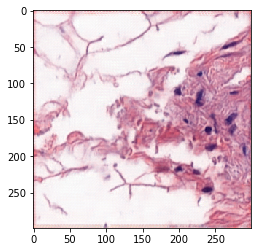

In [ ]:
item = np.random.choice(items)
img = imread(str(item))
plt.imshow(img)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script(fname='_normalize.ipynb')

Converted _normalize.ipynb.
